<a href="https://colab.research.google.com/github/BabiiIn/NLP/blob/main/%D0%A7%D0%B0%D1%81%D1%82%D1%8C_1_(%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B8_1_%D0%B8_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Часть 1

Задача:
1. Сделать EDA
2. Придумать эвристику для предсказания целевого класса. На данном этапе нельзя использовать ML, допускаются исключительно наивные методы, посчитать метрику

#Импорт библиотек

In [ ]:
!pip install spacy
!pip install spacy_langdetect
!python3 -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.1/998.1 KB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993429 sha256=60ba83b696eef17502522ed6976bbf1466b1c48c9bba6b81f265c567ebf782ee
  Stored in directory: /root/.cache/pip/wheels/c1/6d/ab/bf9ecd1ab14dd236da586dfd0d4b008e2e803e571cf2229c26
Successfully built langdetect
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-25 18:15:10.689819: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pip

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
import string
import spacy

from spacy.language import Language
from spacy_langdetect import LanguageDetector
from bs4 import BeautifulSoup
from collections import Counter
from sklearn import metrics
from string import punctuation
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

warnings.filterwarnings('ignore')
%matplotlib inline

#Загрузка и чтение данных

In [ ]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
#  Читаем данные, удаляем id -колонку, меняем названия колонок
train = pd.read_csv('/content/train.csv', encoding="utf8").dropna()
train.drop(train.columns[0], axis=1, inplace=True)
train.rename(columns={'Text': 'text', 'Sentiment': 'label'},
            inplace=True)
train

,text,label
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41154,Airline pilots offering to stock supermarket s...,Neutral
41155,Response to complaint not provided citing COVI...,Extremely Negative
41156,You know itÂs getting tough when @KameronWild...,Positive
41157,Is it wrong that the smell of hand sanitizer i...,Neutral


# EDA

## Пропуски, дубликаты, размерность и тип данных

In [ ]:
# Проверяем наличие пропущенных значений - их нет
train.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# Смотрим размерность данных - массив из 41155 строк и 2-х колонок
train.shape

(41155, 2)

In [ ]:
# Проверяем на дубликаты - их нет
train = train.drop_duplicates()
train.shape


(41155, 2)

In [ ]:
# Данные включают только строковые столбцы
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41155 entries, 0 to 41158
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    41155 non-null  object
 1   label   41155 non-null  object
dtypes: object(2)
memory usage: 964.6+ KB


In [ ]:
train.describe()

,text,label
count,41155,41155
unique,41155,5
top,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Positive
freq,1,11422


## Распределение классов

In [ ]:
# Посмотрим количество классов - их 5
train['label'].nunique()

5

In [ ]:
# Посмотрим распределение классов в абсолютном значении
train.label.value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: label, dtype: int64

In [ ]:
# Посмотрим %-ное распределение классов
train.label.value_counts(normalize = True)

Positive              0.277536
Negative              0.240967
Neutral               0.187365
Extremely Positive    0.160952
Extremely Negative    0.133179
Name: label, dtype: float64

Positive              0.277536
Negative              0.240967
Neutral               0.187365
Extremely Positive    0.160952
Extremely Negative    0.133179
Name: label, dtype: float64


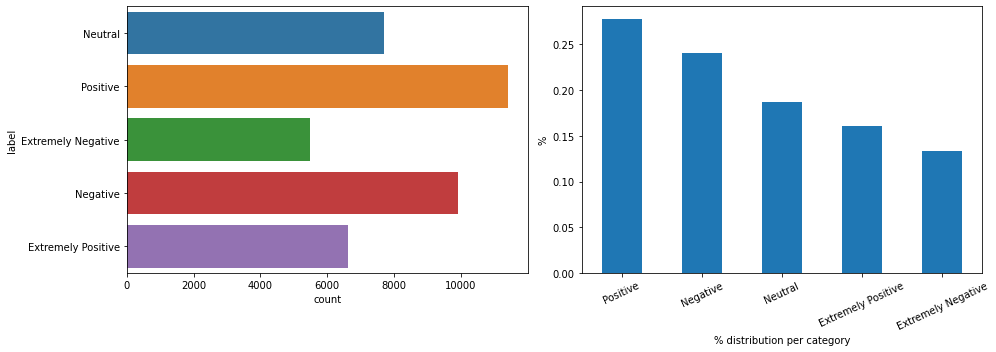

In [ ]:
# Построим распределение классов

stats_target = train['label'].value_counts(normalize=True)
print(stats_target)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(data=train,y='label')
plt.subplot(1,2,2)
stats_target.plot.bar(rot=25)
plt.ylabel('%')
plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

Видим, что у нас 5 классов - Extremely Negative, Negative, Neutral, Positive, Extremely Positive. Классы несбалансированы - минимальное значение отличается от максимального в 2 раза

## Текстовые данные

In [ ]:
# Посмотрим, что из себя представляю тексты
for i in range(0, 5):
    print(i+1)
    print(train['text'][i])
    print(train['label'][i])

1
@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
Neutral
2
advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
Positive
3
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
Positive
4





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
Positive
5




#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n
Extremely Negative


In [ ]:
# Выведем несколько образцов текстов класса Extremely Negative

print('5 random texts with Extremely Negative sentiment: \n')
cl = train.loc[train.label == 'Extremely Negative', ['text']].sample(5).values
i = 1
for c in cl:
    print(i)
    print(c[0])
    print()
    i += 1

5 random texts with Extremely Negative sentiment: 

1






Just think. And stop it.

2

https://t.co/8Ts1Ja4AAC

3
ItÂs so bad that people are selling their food box for cash...this covid 19 is getting people in a Panic mode. @TheView

4


.@SnoopDogg .@BBCNormanS .@F

5


I'm sick myself and people and businesses like you are scumbags #coronavirus #covid19UK



In [ ]:
# Выведем несколько образцов текстов класса Negative

print('5 random texts with Negative sentiment: \n')
cl = train.loc[train.label == 'Negative', ['text']].sample(5).values
i = 1
for c in cl:
    print(i)
    print(c[0])
    print()
    i += 1

5 random texts with Negative sentiment: 

1
Will the epidemic harm UK prices

2

#coronavirus #Palestinians #Palestinian

3
This piece was written in January 2008 by a few months before a massive financial crisis unravelled across the world A good time to revisit this

4






#Covid_19india #Sarcasm #coronavirus #StayAtHomeSaveLives

5
Does any 1 else thinks DT n d GOP r responsible 4 these deaths cused by Covid 19? They failed d USA drastically may they all RIP who lost their lives https://t.co/HUY6719lWa



In [ ]:
# Выведем несколько образцов текстов класса Neutral
print('5 random texts with Neutral sentiment: \n')
cl = train.loc[train.label == 'Neutral', ['text']].sample(5).values
i = 1
for c in cl:
    print(i)
    print(c[0])
    print()
    i += 1

5 random texts with Neutral sentiment: 

1
Kroger swaps Cincy-area store to pickup only. $KR https://t.co/hloracjOEV

2
If I think I will be contacted about #shielding do I go to work tomorrow ? I work in a supermarket , close proximity to many people for 9 hours #RareDisease #COVID?19 #coronavirus

3
The biggest flex right now would be to go toilet paper your neighbors house. #toiletpaper #toiletpapercrisis #toiletpapergate #COVID2019 #coronavirus #CoronavirusPandemic

4




https://t.co/8kx0iWnuux

5
Now that fewer people are in the stores, once-common #ToiletPaper species have begun to return to their native aisle landsÂsome in groups and some all by their shelves. #CoronaVirus https://t.co/GbJnBvyWA7



In [ ]:
# Выведем несколько образцов текстов класса Positive

print('5 random texts with Positive sentiment: \n')
cl = train.loc[train.label == 'Positive', ['text']].sample(5).values
i = 1
for c in cl:
    print(i)
    print(c[0])
    print()
    i += 1

5 random texts with Positive sentiment: 

1
@lidl @iceland and @nationwide have announced special opening times for the vulnerable, share with your patients. Just need @morrisons @sainsburys @asda @tesco and all the supermarket to follow #COVID2019 #kindness #StopPanicBuying

2
#Ausgangssperren #COVID2019 I think its very interesting to see people go grocery shopping with the WHOLE FAMILY... can you not? Whats the point of bringing 5 people to the supermarket. (I work there) and this only highers the risks of infections!

3
The E-Commerce industry flourishes due to the massive change in consumer behavior making brands like IKEA Âtemporarily shutter their stores due to COVID-19 containment.Â https://t.co/zZhQhndvHk

4
Chief Stawinski was out with of Community of Hope AME getting food out to those in need and the two community leaders  message to everyone is please don t panic Hear from them on at 11p

5
My son is working in the front line making sure everyone abides by the social dist

In [ ]:
# Выведем несколько образцов текстов класса Extremely Positive

print('5 random texts with Extremely Positive sentiment: \n')
cl = train.loc[train.label == 'Extremely Positive', ['text']].sample(5).values
i = 1
for c in cl:
    print(i)
    print(c[0])
    print()
    i += 1

5 random texts with Extremely Positive sentiment: 

1


Truly regret just going to my closest Starbucks and supermarket all the time.

2
@NextRevFNC @SteveHiltonx IÂd like to see small businesses keep their 2019 federal taxes. I own a retail store and keeping even a portion of my taxes would be a huge help. I donÂt want a loan. Debt is not the answer. #coronavirus #cuttaxes #Social_Dista

3
Thank you doctors nurses hospital staff paramedics EMTs firemen and women police officers grocery store workers delivery drivers restaurant workers and all of our hero essential workers Sending you all much love Art by artist Sara Paglia

4
Dear genius countrymen and women. Soap works better than hand sanitizer. Toilet paper isn't necessary when you're at home. And there's plenty of food to go around if you'd stop going to the fucking grocery store for a few days. #coronavirus

5
During COVID 19 ALL prices on my ecopies are 0 99 Paperbacks Paths of Righteousness 9 50 There Abideth Hope 9 50 A Very

Видим, что текты, вероятно, на английском языке, содержат  разнообразные знаки препинания, многочисленные символы @,# и т.д., ссылки - https://t.co/iFz9FAn2Pa, а также есть слова с апострофами. Тексты сильно "замусорены".

##Анализ знаков препинания

In [ ]:
# Посмотрим какие и сколько знаков и символов содержат наши данные

train.text.to_csv('count_punct.csv')
with open('count_punct.csv', encoding="utf8") as f:
    c = Counter(c for line in f for c in line if c in punctuation)
print(c)

Counter({'#': 81506, '.': 76491, '/': 74272, ',': 70285, '"': 51374, ':': 30515, '?': 23337, '@': 17841, '-': 16718, "'": 9497, '!': 7598, '_': 5607, ';': 4741, '&': 4195, ')': 2647, '(': 2447, '$': 1538, '%': 1227, '*': 695, '|': 554, '+': 469, '=': 139, ']': 131, '[': 129, '~': 97, '^': 10, '}': 6, '`': 6, '\\': 5, '{': 5})


In [ ]:
# Посмотрим знаки данных класса Extremely Negative

Extremely_Negative = train[(train.label == 'Extremely Negative')]
Extremely_Negative.to_csv('EN_count_punct.csv')
with open('EN_count_punct.csv', encoding="utf8") as f:
    c = Counter(c for line in f for c in line if c in punctuation)
print(c)

Counter({',': 15569, '.': 10504, '#': 8742, '/': 7901, '"': 7264, ':': 3358, '-': 2352, '?': 2306, '@': 2050, "'": 1610, '!': 1205, ';': 765, '_': 675, '&': 652, ')': 378, '(': 350, '$': 218, '%': 160, '*': 135, '+': 75, '|': 60, '=': 28, ']': 15, '[': 14, '~': 11, '^': 2, '\\': 1})


In [ ]:
# Посмотрим знаки данных класса Negative

Negative = train[(train.label == 'Negative')]
Negative.to_csv('N_count_punct.csv')
with open('N_count_punct.csv', encoding="utf8") as f:
    c = Counter(c for line in f for c in line if c in punctuation)
print(c)

Counter({',': 26610, '#': 18245, '.': 18194, '/': 16898, '"': 12314, ':': 6988, '?': 4695, '@': 4283, '-': 4117, "'": 2320, '!': 1622, '_': 1323, ';': 1023, '&': 870, ')': 595, '(': 548, '$': 349, '%': 322, '*': 193, '|': 141, '+': 107, '[': 38, ']': 38, '=': 35, '~': 35, '`': 5, '}': 1})


In [ ]:
# Посмотрим знаки данных класса Extremely Positive

Extremely_Positive = train[(train.label == 'Extremely Positive')]
Extremely_Positive.to_csv('EP_count_punct.csv')
with open('EP_count_punct.csv', encoding="utf8") as f:
    c = Counter(c for line in f for c in line if c in punctuation)
print(c)

Counter({',': 19050, '.': 13508, '#': 12579, '/': 11423, '"': 8868, ':': 4591, '?': 3398, '@': 3058, '-': 2689, '!': 1822, "'": 1698, ';': 1111, '&': 1037, '_': 940, ')': 504, '(': 440, '$': 221, '%': 196, '*': 113, '+': 95, '|': 70, '=': 33, '~': 21, ']': 17, '[': 16, '^': 6, '{': 4, '}': 4, '`': 1})


In [ ]:
# Посмотрим знаки данных класса Positive

Positive = train[(train.label == 'Positive')]
Positive.to_csv('P_count_punct.csv')
with open('P_count_punct.csv', encoding="utf8") as f:
    c = Counter(c for line in f for c in line if c in punctuation)
print(c)

Counter({',': 31213, '#': 22137, '.': 21443, '/': 21069, '"': 14506, ':': 8657, '?': 5576, '@': 5104, '-': 4666, "'": 2683, '!': 1971, '_': 1498, ';': 1321, '&': 1192, ')': 747, '(': 711, '$': 452, '%': 335, '*': 154, '|': 154, '+': 132, '[': 35, ']': 35, '=': 25, '~': 17, '\\': 3, '^': 1})


In [ ]:
# Посмотрим знаки данных класса Neutral

Neutral = train[(train.label == 'Neutral')]
Neutral.to_csv('N_count_punct.csv')
with open('N_count_punct.csv', encoding="utf8") as f:
    c = Counter(c for line in f for c in line if c in punctuation)
print(c)

Counter({'#': 19803, ',': 19007, '/': 16981, '.': 12842, '"': 8422, '?': 7362, ':': 6921, '@': 3346, '-': 2894, "'": 1186, '_': 1171, '!': 978, ';': 521, '&': 444, ')': 423, '(': 398, '$': 298, '%': 214, '|': 129, '*': 100, '+': 60, '[': 26, ']': 26, '=': 18, '~': 13, '{': 1, '}': 1, '\\': 1, '^': 1})


Наиболее часто в тексте встречаются следующие знаки: # . / , "






*   При этом, в классе Extremely Negative наиболее популярные: , . # / "



*   В классе Extremely Positive: , . # / "
*   В классе Positive: , # . / "



*   В классе Neutral: # , / . "

*   В классе Negative: , # . / "


Мы видим, что в каждом классе наиболее часто встречающими знаками препинания является один и тот же набор символов.
Он характере и для всего набора в целом.
Поэтому выстроить классификации на основе наличия определенных знаков не получится.

##Очистка текста

Удалим из текста знаки препинания, служебные слова и символы, цифры, а также раскроем слова с апострофами

In [ ]:
# Раскроем словосочетания с апострофами

# Список словосочетаний с апострофами
contraction_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "cannot",
                    "'cause": "because",
                    "could've": "could have",
                    "couldn't": "could not",
                    "didn't": "did not",
                    "doesn't": "does not",
                    "don't": "do not",
                    "hadn't": "had not",
                    "hasn't": "has not",
                    "haven't": "have not",
                    "he'd": "he would",
                    "he'll": "he will",
                    "he's": "he is",
                    "how'd": "how did",
                    "how'd'y": "how do you",
                    "how'll": "how will",
                    "how's": "how is",
                    "I'd": "I would",
                    "I'd've": "I would have",
                    "I'll": "I will",
                    "I'll've": "I will have",
                    "I'm": "I am",
                    "I've": "I have",
                    "i'd": "i would",
                    "i'd've": "i would have",
                    "i'll": "i will",
                    "i'll've": "i will have",
                    "i'm": "i am",
                    "i've": "i have",
                    "isn't": "is not",
                    "it'd": "it would",
                    "it'd've": "it would have",
                    "it'll": "it will",
                    "it'll've": "it will have",
                    "it's": "it is",
                    "let's": "let us",
                    "ma'am": "madam",
                    "mayn't": "may not",
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have",
                    "must've": "must have",
                    "mustn't": "must not",
                    "mustn't've": "must not have",
                    "needn't": "need not",
                    "needn't've": "need not have",
                    "o'clock": "of the clock",
                    "oughtn't": "ought not",
                    "oughtn't've": "ought not have",
                    "shan't": "shall not",
                    "sha'n't": "shall not",
                    "shan't've": "shall not have",
                    "she'd": "she would",
                    "she'd've": "she would have",
                    "she'll": "she will",
                    "she'll've": "she will have",
                    "she's": "she is",
                    "should've": "should have",
                    "shouldn't": "should not",
                    "shouldn't've": "should not have",
                    "so've": "so have",
                    "so's": "so as",
                    "this's": "this is",
                    "that'd": "that would",
                    "that'd've": "that would have",
                    "that's": "that is",
                    "there'd": "there would",
                    "there'd've": "there would have",
                    "there's": "there is",
                    "here's": "here is",
                    "they'd": "they would",
                    "they'd've": "they would have",
                    "they'll": "they will",
                    "they'll've": "they will have",
                    "they're": "they are",
                    "they've": "they have",
                    "to've": "to have",
                    "wasn't": "was not",
                    "we'd": "we would",
                    "we'd've": "we would have",
                    "we'll": "we will",
                    "we'll've": "we will have",
                    "we're": "we are",
                    "we've": "we have",
                    "weren't": "were not",
                    "what'll": "what will",
                    "what'll've": "what will have",
                    "what're": "what are",
                    "what's": "what is",
                    "what've": "what have",
                    "when's": "when is",
                    "when've": "when have",
                    "where'd": "where did",
                    "where's": "where is",
                    "where've": "where have",
                    "who'll": "who will",
                    "who'll've": "who will have",
                    "who's": "who is",
                    "who've": "who have",
                    "why's": "why is",
                    "why've": "why have",
                    "will've": "will have",
                    "won't": "will not",
                    "won't've": "will not have",
                    "would've": "would have",
                    "wouldn't": "would not",
                    "wouldn't've": "would not have",
                    "y'all": "you all",
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would",
                    "you'd've": "you would have",
                    "you'll": "you will",
                    "you'll've": "you will have",
                    "you're": "you are",
                    "you've": "you have"}

# Создадим функции, раскрывающие словосочетания с апострофами

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))

    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]

    return contractions_re.sub(replace, text)

# Применим функцию, раскрывающую словосочетания с апострофами

train.text = train.text.apply(lambda x: replace_contractions(x))

In [ ]:
# Создадим функцию для очистки теста
def clean(text: str):
    emojis = r'[\U0001F600-\U0001F64F'\
           + r'\U0001F300-\U0001F5FF'\
           + r'\U0001F680-\U0001F6FF'\
           + r'\U0001F1E0-\U0001F1FF'\
           + r'\U00002702-\U000027B0'\
           + r'\U000024C2-\U0001F251]+'
    non_ASCII = r'[^\x00-\x7F]+'
    mentions = r'@[A-Za-z0-9_-]+'
    urls = r'https?://[A-Za-z0-9./]+'
    punctuation = r'[.,#!$%\^&\*;:{}=\-_`~()]'
    punctuation_space = r'[\/\\]'
    whitespace = r'\s+'

    # The text sometimes contains html elements, clean it up
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text()

    # Replace all non-ASCII characters with space
    text = re.sub(non_ASCII, ' ', text)
    # Replace all emojis with space
    text = re.sub(emojis, ' ', text)
    # Remove Twitter mentions with usernames
    text = re.sub(mentions, '', text)
    # Remove all urls
    text = re.sub(urls, '', text)
    # Remove the punctuation marks
    text = re.sub(punctuation, '', text)
    # Removing some punctuation marks will fuse the words,
    # replace them with space instead
    text = re.sub(punctuation_space, ' ', text)
    # Remove multiple spaces, tabs and other whitespaces with one space
    text = re.sub(whitespace, ' ', text)

    # Convert text to lower case
    text = text.lower()

    return text

In [ ]:
# Применим функцию
train['text'] = train['text'].apply(clean)
train

,text,label
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the covid...,Extremely Negative
...,...,...
41154,airline pilots offering to stock supermarket s...,Neutral
41155,response to complaint not provided citing covi...,Extremely Negative
41156,you know it s getting tough when is rationing ...,Positive
41157,is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
# Доочистим то, что не очистилось

def clear_text(text: str) -> str:

    mentions = r'@[A-Za-z0-9_-]+'
    urls = r'https?://[A-Za-z0-9./]+'
    punct = r'[.,#!/Â"?$%\^&\*;:{}=\-_`~()]'
    pattern = r'[^a-zA-z0-9@\$\s]'

    for regx in [mentions, urls, punct, pattern]:
        text = re.sub(regx, ' ', text)

    for regx in [pattern]:
        text = re.sub(pattern, '', text)

    text = re.sub('\s+',' ', text)
    text = re.sub('[0-9]', '', text)

    return text

In [ ]:
# Применим функцию по очистке текста

train['text'] = train['text'].apply(clear_text)
train

,text,label
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the covid...,Extremely Negative
...,...,...
41154,airline pilots offering to stock supermarket s...,Neutral
41155,response to complaint not provided citing covi...,Extremely Negative
41156,you know it s getting tough when is rationing ...,Positive
41157,is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
# Поиск знаков препинания
if any(x in string.punctuation for x in train.text):
    print("that string contains punctuation")
else:
    print("that string contains no punctuation")

that string contains no punctuation


Очистим текст от не английских слов

In [ ]:
# load english vocab and create pipeline
def get_lang_detector(nlp, name):
    return LanguageDetector()
nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)
# use created pipeline for language detect
def detect_lan(text) :
    doc = nlp(text)
    detect_language = doc._.language
    detect_language = detect_language['language']
    return(detect_language)
# create a new column called "nation" to record detect language
train['nation'] = train['text'].apply(lambda x: detect_lan(x))
# group by nation and count for each nation
dict(train.groupby('nation').count())

{'text': nation
 UNKNOWN       31
 af            11
 ca            28
 cy             2
 da             9
 de             9
 en         40871
 es            34
 et             4
 fi             5
 fr            50
 id             2
 it            40
 nl             9
 no            14
 pl             1
 pt             6
 ro             9
 sk             2
 sl             1
 so             1
 sq             1
 sv             2
 sw             1
 tl             7
 tr             4
 vi             1
 Name: text, dtype: int64, 'label': nation
 UNKNOWN       31
 af            11
 ca            28
 cy             2
 da             9
 de             9
 en         40871
 es            34
 et             4
 fi             5
 fr            50
 id             2
 it            40
 nl             9
 no            14
 pl             1
 pt             6
 ro             9
 sk             2
 sl             1
 so             1
 sq             1
 sv             2
 sw             1
 tl             7
 tr  

In [ ]:
# Имеется 284 не английских слова
sum(train['nation'][train['nation']!="en"].value_counts())

284

In [ ]:
# Оставим только слова на английском языке
train = train[train['nation']=="en"]

In [ ]:
# Проверим, что не осталось слов на неанлийском языке
sum(train['nation'][train['nation']!="en"].value_counts())

0

In [ ]:
from unicodedata import normalize
# Функция для очистки текста от лишних символов
def clean_text(text):
    """ Removes special characters """
    special_characters = 'å¼«¥ª°©ð±§µæ¹¢³¿®ä£'
    text = text.translate(str.maketrans('', '', special_characters))

    """ Normalize unicode data to remove umlauts, and accents, etc. """
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf8')

    # """ Remove any character except alphanumeric characters """
    # text =  ''.join(c for c in text if c.isalnum())


    # регулярное выражение для удаления символов
    punctuation_space = r'[\/\\]'
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\$\=+\+\]\[\%\&\^\.+\;\,\@\+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # регулярное выражение для замены упоминаний
    mentions = r'@[A-Za-z0-9_-]+'

    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, ' ', text)
    # удаляем числа и цифры
    text = re.sub(r'(\d+\s\d+)|(\d+)', ' ', text)
    # удаляем ссылки
    text = re.sub(mentions, '', text)
    # заменяем знаки на пробелы
    text = re.sub(punctuation_space, ' ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(word for word in text.split() if word not in stopwords)

    # приводим текст к нижнему регистру
    text = text.lower()
    # возвращаем очищенные данные

    return text

In [ ]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS

In [ ]:
# удаляем ненужные символы из текста
train['text'] = tqdm(train['text'].apply(clean_text))
train

100%|██████████| 40871/40871 [00:00<00:00, 1629921.83it/s]


,text,label,nation
0,,Neutral,en
1,advice talk neighbours family exchange phone n...,Positive,en
2,coronavirus australia woolworths elderly disab...,Positive,en
3,food stock panic food need stay calm stay safe...,Positive,en
4,ready supermarket covid outbreak paranoid food...,Extremely Negative,en
...,...,...,...
41154,airline pilots offering stock supermarket shel...,Neutral,en
41155,response complaint provided citing covid relat...,Extremely Negative,en
41156,know s getting tough rationing toilet paper co...,Positive,en
41157,wrong smell hand sanitizer starting turn coron...,Neutral,en


In [ ]:
train.drop(columns = "nation", inplace=True)
train

,text,label
0,,Neutral
1,advice talk neighbours family exchange phone n...,Positive
2,coronavirus australia woolworths elderly disab...,Positive
3,food stock panic food need stay calm stay safe...,Positive
4,ready supermarket covid outbreak paranoid food...,Extremely Negative
...,...,...
41154,airline pilots offering stock supermarket shel...,Neutral
41155,response complaint provided citing covid relat...,Extremely Negative
41156,know s getting tough rationing toilet paper co...,Positive
41157,wrong smell hand sanitizer starting turn coron...,Neutral


In [ ]:
# Сохранение файла для использования в дальнейших частях заданиях
train.to_csv('/content/df.csv')

##Длина предложений

In [ ]:
# Среднее количество слов в предложении во всем наборе данных - 30 слов

np.mean([len(s.split(" ")) for s in train.text])

30.178593123557285

In [ ]:
# Среднее количество слов в предложениях класса Positive - 31 слово

Positive = train[(train.label == 'Positive')]
np.mean([len(s.split(" ")) for s in Positive['text']])

30.595867623883734

In [ ]:
# Среднее количество слов в предложениях класса Neutral - 23 слова

Neutral = train[(train.label == 'Neutral')]
np.mean([len(s.split(" ")) for s in Neutral['text']])

22.60082998314097

In [ ]:
# Среднее количество слов в предложениях класса Extremely Negative - 34 слова

Extremely_Negative = train[(train.label == 'Extremely Negative')]
np.mean([len(s.split(" ")) for s in Extremely_Negative['text']])

34.344462689290275

In [ ]:
# Среднее количество слов в предложениях класса Negative - 30

Negative = train[(train.label == 'Negative')]
np.mean([len(s.split(" ")) for s in Negative['text']])

30.403851971362307

In [ ]:
# Среднее количество слов в предложениях класса Extremely Positive - 34 слова

Extremely_Positive = train[(train.label == 'Extremely Positive')]
np.mean([len(s.split(" ")) for s in Extremely_Positive['text']])

34.49607487922705

Среднее количество слов в предложениях во всем наборе данных - 30 слов.
При этом,





*   в предложениях класса Extremely Negative - 34 слова
*   в предложениях класса Negative - 30 слов



*   в предложениях класса Neutral - 23 слова
*   в предложениях класса Positive - 31 слово



*   в предложениях класса Extremely Positive - 34 слова




Отличается от остальных класс Neutral, в нем наименьшее количество слов - 23.
В остальных классах примерно равное количество слов - от 30 до 34.
Учитывая отсутствие значимых отличий в длине предложений между классами выстраивать классификацию на основании данного критерия нецелесообразно.

#Наиболее часто встречающиеся слова и группы слов (unigrams, bigrams, trigrams)

##Unigrams

In [ ]:
# Top unigrams before removing stop words

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

common_words = get_top_n_words(train['text'], 20)

for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])

the 44822
to 38358
and 24034
covid 21888
of 21522
in 19147
coronavirus 18060
for 14050
is 13420
are 12010
you 10068
on 9407
this 7960
prices 7913
at 7781
it 7384
food 7108
supermarket 7053
we 7012
store 6828


In [ ]:
# Top unigrams after removing stop words

def get_top_n_words_after(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

common_words = get_top_n_words_after(train['text'], 20)

for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

covid 21888
coronavirus 18060
prices 7913
food 7108
supermarket 7053
store 6828
grocery 6263
people 5590
consumer 4518
shopping 3612
online 3435
pandemic 3175
need 2712
workers 2591
just 2582
panic 2472
sanitizer 2388
like 2366
time 2281
demand 2278


In [ ]:
# Top unigrams after removing stop words
# класс Extremely Negative

Extremely_Negative = train[(train.label == 'Extremely Negative')]
common_words = get_top_n_words_after(Extremely_Negative['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_EN = pd.DataFrame(common_words, columns = ['text' , 'count'])

covid 2888
coronavirus 2411
food 1584
prices 1350
people 1246
panic 1147
supermarket 938
crisis 841
store 671
buying 652
grocery 645
consumer 512
oil 472
just 456
stop 444
need 438
demand 374
pandemic 361
going 345
shopping 317


In [ ]:
# Top unigrams after removing stop words
# класс Negative

Negative = train[(train.label == 'Negative')]
common_words = get_top_n_words_after(Negative['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_N = pd.DataFrame(common_words, columns = ['text' , 'count'])

covid 5161
coronavirus 4329
prices 2372
food 2035
supermarket 1744
store 1531
people 1439
grocery 1416
consumer 963
demand 897
panic 829
pandemic 827
shopping 734
online 678
oil 650
just 627
need 618
time 583
workers 557
buying 529


In [ ]:
# Top unigrams after removing stop words
# класс Extremely Positive

Extremely_Positive = train[(train.label == 'Extremely Positive')]
common_words = get_top_n_words_after(Extremely_Positive['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_EP = pd.DataFrame(common_words, columns = ['text' , 'count'])

covid 3456
coronavirus 2664
store 1268
supermarket 1093
grocery 1080
food 1000
help 980
hand 943
prices 937
sanitizer 913
people 847
like 770
consumer 736
workers 718
online 712
shopping 709
thank 537
safe 537
need 517
pandemic 503


In [ ]:
# Top unigrams after removing stop words
# класс Positive

Positive = train[(train.label == 'Positive')]
common_words = get_top_n_words_after(Positive['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_P = pd.DataFrame(common_words, columns = ['text' , 'count'])

covid 6173
coronavirus 4847
store 2032
prices 2028
grocery 1936
supermarket 1931
food 1809
people 1451
consumer 1315
shopping 1093
online 1085
like 916
pandemic 915
sanitizer 864
hand 840
need 796
workers 792
help 723
just 689
demand 685


In [ ]:
# Top unigrams after removing stop words
# класс Neutral

Neutral = train[(train.label == 'Neutral')]
common_words = get_top_n_words_after(Neutral['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_Neu = pd.DataFrame(common_words, columns = ['text' , 'count'])

covid 4210
coronavirus 3809
supermarket 1347
store 1326
prices 1226
grocery 1186
consumer 992
shopping 759
online 695
food 680
people 607
pandemic 569
toiletpaper 551
new 369
just 362
retail 350
need 343
home 329
toilet 327
paper 310


###Наиболее популярные unigrams для каждого класса

In [ ]:
# Выведем таблицу с наиболее популярными unigrams для каждого класса
# Видим что unigrams пересекаются

table = pd.DataFrame(columns=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
table['Extremely Negative'] = df_EN.text
table['Negative'] = df_N.text
table['Neutral'] = df_Neu.text
table['Positive'] = df_P.text
table['Extremely Positive'] = df_EP.text

table

,Extremely Negative,Negative,Neutral,Positive,Extremely Positive
0,covid,covid,covid,covid,covid
1,coronavirus,coronavirus,coronavirus,coronavirus,coronavirus
2,food,prices,supermarket,store,store
3,prices,food,store,prices,supermarket
4,people,supermarket,prices,grocery,grocery
5,panic,store,grocery,supermarket,food
6,supermarket,people,consumer,food,help
7,crisis,grocery,shopping,people,hand
8,store,consumer,online,consumer,prices
9,buying,demand,food,shopping,sanitizer


Много одинаковых слов в каждом классе, классификация на основании Top unigrams нецелессобразна

##Bigrams

In [ ]:
# Top bigrams before removing stop words

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

common_words = get_top_n_bigram(train['text'], 20)

for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store 4738
to the 3879
in the 3646
of the 3053
coronavirus covid 2250
the coronavirus 2179
the grocery 2136
covid coronavirus 1943
the covid 1931
the supermarket 1885
due to 1790
at the 1708
on the 1644
for the 1539
of covid 1520
hand sanitizer 1519
if you 1401
online shopping 1345
to be 1286
during the 1265


In [ ]:
# Top bigrams after removing stop words

def get_top_n_bigram_after(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

common_words = get_top_n_bigram_after(train['text'], 20)

for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store 4740
coronavirus covid 2272
covid coronavirus 1952
hand sanitizer 1524
online shopping 1351
toilet paper 1226
covid pandemic 1117
panic buying 1074
oil prices 987
covid covid 799
coronavirus pandemic 760
social distancing 629
stay home 500
supermarket shelves 462
store workers 462
covid crisis 452
covid outbreak 437
gas prices 397
shopping online 386
coronavirus outbreak 380


In [ ]:
# Top bigrams after removing stop words
# класс Extremely Negative

common_words = get_top_n_bigram_after(Extremely_Negative['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_EN2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

panic buying 527
grocery store 475
coronavirus covid 256
oil prices 249
covid crisis 208
covid coronavirus 188
toilet paper 157
coronavirus crisis 154
covid pandemic 118
stop panic 118
supermarket shelves 112
online shopping 103
coronavirus pandemic 77
supply chain 75
covid covid 73
panic buyers 71
panic buy 70
price gouging 66
social distancing 65
amid covid 62


In [ ]:
# Top bigrams after removing stop words
# класс Negative

common_words = get_top_n_bigram_after(Negative['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_N2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store 1077
coronavirus covid 461
covid coronavirus 402
oil prices 401
panic buying 376
toilet paper 301
online shopping 297
covid pandemic 270
coronavirus pandemic 229
covid covid 188
supermarket shelves 143
covid crisis 139
social distancing 139
gas prices 131
hand sanitizer 121
covid outbreak 114
coronavirus outbreak 109
amid covid 107
food banks 104
stay home 103


In [ ]:
# Top bigrams after removing stop words
# класс Neutral

common_words = get_top_n_bigram_after(Neutral['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_Neu2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store 892
coronavirus covid 554
covid coronavirus 444
online shopping 305
toilet paper 277
covid covid 215
covid pandemic 195
coronavirus pandemic 164
social distancing 121
oil prices 115
consumer behavior 106
coronavirus toiletpaper 102
covid outbreak 92
coronavirus outbreak 86
grocery shopping 79
gas prices 74
shopping online 73
retail store 72
amid covid 72
local supermarket 66


In [ ]:
# Top bigrams after removing stop words
# класс Positive

common_words = get_top_n_bigram_after(Positive['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_P2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store 1421
coronavirus covid 656
hand sanitizer 634
covid coronavirus 576
online shopping 394
covid pandemic 346
toilet paper 326
covid covid 205
social distancing 191
coronavirus pandemic 180
oil prices 176
stay home 163
store workers 150
grocery stores 123
covid outbreak 122
grocery shopping 122
supermarket shelves 114
shopping online 113
stock food 112
panic buying 112


In [ ]:
# Top bigrams after removing stop words
# класс Extremely Positive

common_words = get_top_n_bigram_after(Extremely_Positive['text'], 20)
for word, freq in common_words:
    print(word, freq)
df_EP2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store 875
hand sanitizer 698
coronavirus covid 345
covid coronavirus 342
online shopping 252
covid pandemic 188
stay safe 178
toilet paper 165
store workers 136
covid covid 118
stay home 117
social distancing 113
shopping online 111
coronavirus pandemic 110
supermarket workers 100
store employees 86
make sure 76
covid outbreak 75
retail store 73
health care 73


###Наиболее популярные bigrams для каждого класса

In [ ]:
# Выведем таблицу с наиболее популярными bigrams для каждого класса
# Eсть общие bigrams

table_bigrams = pd.DataFrame(columns=['Extremely Negative', 'Negative',
                             'Neutral', 'Positive', 'Extremely Positive'])
table_bigrams['Extremely Negative'] = df_EN2.text
table_bigrams['Negative'] = df_N2.text
table_bigrams['Neutral'] = df_Neu2.text
table_bigrams['Positive'] = df_P2.text
table_bigrams['Extremely Positive'] = df_EP2.text

table_bigrams

,Extremely Negative,Negative,Neutral,Positive,Extremely Positive
0,panic buying,grocery store,grocery store,grocery store,grocery store
1,grocery store,coronavirus covid,coronavirus covid,coronavirus covid,hand sanitizer
2,coronavirus covid,covid coronavirus,covid coronavirus,hand sanitizer,coronavirus covid
3,oil prices,oil prices,online shopping,covid coronavirus,covid coronavirus
4,covid crisis,panic buying,toilet paper,online shopping,online shopping
5,covid coronavirus,toilet paper,covid covid,covid pandemic,covid pandemic
6,toilet paper,online shopping,covid pandemic,toilet paper,stay safe
7,coronavirus crisis,covid pandemic,coronavirus pandemic,covid covid,toilet paper
8,covid pandemic,coronavirus pandemic,social distancing,social distancing,store workers
9,stop panic,covid covid,oil prices,coronavirus pandemic,covid covid


Много одинаковых групп слов в каждом классе, классификация на основании Top bigrams нецелессобразна

##Trigrams

In [ ]:
# Top trigrams before removing stop words

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

common_words = get_top_n_trigram(train['text'], 30)

for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['text' , 'count'])

the grocery store 2030
to the grocery 888
the covid pandemic 677
to the supermarket 607
at the grocery 540
due to covid 515
go to the 489
due to the 487
the coronavirus pandemic 470
the spread of 456
grocery store workers 430
during the covid 395
during the coronavirus 384
to go to 342
going to the 339
of the coronavirus 333
in the supermarket 311
at the supermarket 309
stock up on 304
the coronavirus outbreak 275
grocery store and 271
of the covid 270
the covid crisis 269
the covid outbreak 260
spread of covid 256
if you are 254
to stock up 250
went to the 241
there is no 239
to the coronavirus 238


In [ ]:
# Top trigrams after removing stop words

def get_top_n_trigram_after(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    return words_freq[:n]

common_words = get_top_n_trigram_after(train['text'], 30)

for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

grocery store workers 433
grocery store employees 238
going grocery store 208
coronavirus covid covid 183
local grocery store 161
stop panic buying 153
went grocery store 149
covid covid covid 141
covid covid coronavirus 134
online grocery shopping 118
grocery store covid 107
work grocery store 97
workers grocery store 97
grocery store today 93
grocery store coronavirus 92
grocery store clerks 91
panic buying food 88
low oil prices 88
food supply chain 87
use hand sanitizer 86
amid covid pandemic 82
grocery store shelves 77
making hand sanitizer 74
covid coronavirus covid 72
amid coronavirus pandemic 71
tested positive covid 70
grocery store pharmacy 69
people panic buying 69
toilet paper coronavirus 69
coronavirus covid pandemic 69


In [ ]:
# Top trigrams after removing stop words
# класс Extremely Negative

common_words = get_top_n_trigram_after(Extremely_Negative['text'], 30)
for word, freq in common_words:
    print(word, freq)
df_EN3 = pd.DataFrame(common_words, columns = ['text' , 'count'])

stop panic buying 106
panic buying food 46
grocery store workers 44
people panic buying 40
food supply chain 29
crude oil prices 28
paid sick leave 25
covid panic buying 25
going grocery store 25
low oil prices 24
amid covid crisis 24
amid covid panic 21
workers beginning die 21
grocery workers beginning 20
saudi arabia russia 19
panic buying covid 19
trader joe giant 19
panic buying hoarding 18
oil price war 18
beginning die coronavirus 18
walmart trader joe 18
joe giant died 18
died covid recent 18
covid recent days 18
coronavirus panic buying 17
covid covid covid 17
grocery store employees 17
coronavirus covid covid 17
giant died covid 17
went grocery store 16


In [ ]:
# Top trigrams after removing stop words
# класс Negative

common_words = get_top_n_trigram_after(Negative['text'], 30)
for word, freq in common_words:
    print(word, freq)
df_N3 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store workers 83
going grocery store 48
went grocery store 42
coronavirus covid covid 41
local grocery store 40
low oil prices 36
covid covid covid 35
stop panic buying 34
panic buying food 31
amid coronavirus pandemic 29
grocery store employees 28
covid covid coronavirus 28
crude oil prices 27
work grocery store 26
grocery store shelves 26
food supply chain 26
global oil prices 24
covid panic buying 23
falling oil prices 23
online grocery shopping 22
grocery store coronavirus 21
grocery store covid 20
amid covid outbreak 20
working grocery store 19
people panic buying 18
grocery store today 18
collapse oil prices 18
grocery store worker 17
lower oil prices 17
amid covid pandemic 17


In [ ]:
# Top trigrams after removing stop words
# класс Neutral

common_words = get_top_n_trigram_after(Neutral['text'], 30)
for word, freq in common_words:
    print(word, freq)
df_Neu3 = pd.DataFrame(common_words, columns = ['text' , 'count'])

coronavirus covid covid 57
going grocery store 43
grocery store workers 42
local grocery store 41
grocery store covid 40
online grocery shopping 35
grocery store coronavirus 35
covid covid coronavirus 33
covid covid covid 29
went grocery store 26
amid covid pandemic 25
grocery store employees 24
grocery store today 23
grocery store pharmacy 18
retail store closures 17
covid coronavirus covid 17
toilet paper coronavirus 17
covid coronavirus toiletpaper 16
line grocery store 16
covid covid corona 16
covid coronavirusupdate covid 16
stoppanicbuying coronavirus panicshopping 15
coronavirus panicshopping panicbuyinguk 15
panicshopping panicbuyinguk coronavirus 15
panicbuyinguk coronavirus covid 15
coronavirus covid coronavirusupdate 15
coronavirusupdate covid socialdistanacing 15
toiletpaper covid coronavirus 15
online shopping behavior 14
coronacrisis stopstockpiling stoppanicbuying 14


In [ ]:
# Top trigrams after removing stop words
# класс Positive

common_words = get_top_n_trigram_after(Positive['text'], 30)
for word, freq in common_words:
    print(word, freq)
df_P3 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store workers 138
grocery store employees 89
going grocery store 59
coronavirus covid covid 45
online grocery shopping 43
use hand sanitizer 42
went grocery store 40
local grocery store 40
covid covid coronavirus 37
tested positive covid 36
workers grocery store 34
grocery store clerks 34
hand sanitizer coronavirus 33
work grocery store 31
sanitizer italy wuhan 30
italy wuhan grocery 30
amid covid pandemic 29
covid covid covid 28
making hand sanitizer 28
toilet paper hand 27
grocery store covid 27
paper hand sanitizer 26
grocery store like 26
grocery store today 25
amid coronavirus pandemic 25
grocery store coronavirus 24
coronavirus covid pandemic 23
line grocery store 22
coronavirus covid contest 22
covid contest alert 22


In [ ]:
# Top trigrams after removing stop words
# класс Extremely Positive

common_words = get_top_n_trigram_after(Extremely_Positive['text'], 30)
for word, freq in common_words:
    print(word, freq)
df_EP3 = pd.DataFrame(common_words, columns = ['text' , 'count'])

grocery store workers 126
grocery store employees 80
health care workers 43
workers grocery store 41
use hand sanitizer 38
make hand sanitizer 38
going grocery store 33
making hand sanitizer 33
covid covid covid 32
grocery store clerks 29
thank grocery store 27
local grocery store 26
went grocery store 25
work grocery store 25
covid covid coronavirus 25
stay safe stay 23
hand sanitizer coronavirus 23
coronavirus covid covid 23
tested positive covid 22
stay home stay 20
meet increased demand 20
masks hand sanitizer 18
care workers grocery 17
workers delivery drivers 17
support local businesses 17
prevent spread covid 15
grocery store staff 15
committed helping customers 15
using hand sanitizer 15
trip grocery store 15


###Наиболее популярные trigrams для каждого класса

In [ ]:
# Выведем таблицу с наиболее популярными trigrams для каждого класса

table_trigrams = pd.DataFrame(columns=['Extremely Negative', 'Negative',
                              'Neutral', 'Positive', 'Extremely Positive'])
table_trigrams['Extremely Negative'] = df_EN3.text
table_trigrams['Negative'] = df_N3.text
table_trigrams['Neutral'] = df_Neu3.text
table_trigrams['Positive'] = df_P3.text
table_trigrams['Extremely Positive'] = df_EP3.text

table_trigrams

,Extremely Negative,Negative,Neutral,Positive,Extremely Positive
0,stop panic buying,grocery store workers,coronavirus covid covid,grocery store workers,grocery store workers
1,panic buying food,going grocery store,going grocery store,grocery store employees,grocery store employees
2,grocery store workers,went grocery store,grocery store workers,going grocery store,health care workers
3,people panic buying,coronavirus covid covid,local grocery store,coronavirus covid covid,workers grocery store
4,food supply chain,local grocery store,grocery store covid,online grocery shopping,use hand sanitizer
5,crude oil prices,low oil prices,online grocery shopping,use hand sanitizer,make hand sanitizer
6,paid sick leave,covid covid covid,grocery store coronavirus,went grocery store,going grocery store
7,covid panic buying,stop panic buying,covid covid coronavirus,local grocery store,making hand sanitizer
8,going grocery store,panic buying food,covid covid covid,covid covid coronavirus,covid covid covid
9,low oil prices,amid coronavirus pandemic,went grocery store,tested positive covid,grocery store clerks


#Классификация текстов на основании наиболее популярных для каждого класса trigrams

Каждый класс будем определять по наличию в нем наиболее популярных trigrams, характерных для данного класса

In [ ]:
# Для того, чтобы убрать пересечения trigrams,
# Переведем списки trigrams в множества

col_EN = set(table_trigrams["Extremely Negative"])
col_N = set(table_trigrams["Negative"])
col_Neu = set(table_trigrams["Neutral"])
col_P = set(table_trigrams["Positive"])
col_EP = set(table_trigrams["Extremely Positive"])

In [ ]:
# Составим список из trigrams, которые встречаются только
# в классе Extremely Negative

list_EN = []
for i in col_EN:
    if i not in col_N:
        if i not in col_Neu:
            if i not in col_P:
                if i not in col_EP:
                    list_EN.append(i)
print(list_EN)
print(len(list_EN))

['paid sick leave', 'saudi arabia russia', 'trader joe giant', 'panic buying covid', 'beginning die coronavirus', 'giant died covid', 'walmart trader joe', 'panic buying hoarding', 'amid covid crisis', 'coronavirus panic buying', 'workers beginning die', 'covid recent days', 'amid covid panic', 'joe giant died', 'died covid recent', 'oil price war', 'grocery workers beginning']
17


In [ ]:
# Составим список из trigrams, которые встречаются только
# в классе Negative

list_N = []
for i in col_N:
    if i not in col_EN:
        if i not in col_Neu:
            if i not in col_P:
                if i not in col_EP:
                    list_N.append(i)
print(list_N)
print(len(list_N))

['working grocery store', 'falling oil prices', 'grocery store shelves', 'collapse oil prices', 'global oil prices', 'lower oil prices', 'grocery store worker', 'amid covid outbreak']
8


In [ ]:
# Составим список из trigrams, которые встречаются только
# в классе Neutral

list_Neu = []
for i in col_Neu:
    if i not in col_EN:
        if i not in col_N:
            if i not in col_P:
                if i not in col_EP:
                    list_Neu.append(i)
print(list_Neu)
print(len(list_Neu))

['covid coronavirus toiletpaper', 'grocery store pharmacy', 'panicbuyinguk coronavirus covid', 'coronacrisis stopstockpiling stoppanicbuying', 'coronavirus covid coronavirusupdate', 'online shopping behavior', 'toiletpaper covid coronavirus', 'covid covid corona', 'coronavirusupdate covid socialdistanacing', 'retail store closures', 'covid coronavirus covid', 'covid coronavirusupdate covid', 'panicshopping panicbuyinguk coronavirus', 'stoppanicbuying coronavirus panicshopping', 'coronavirus panicshopping panicbuyinguk', 'toilet paper coronavirus']
16


In [ ]:
# Составим список из trigrams, которые встречаются только
# в классе Positive

list_P = []
for i in col_P:
    if i not in col_EN:
        if i not in col_N:
            if i not in col_Neu:
                if i not in col_EP:
                    list_P.append(i)
print(list_P)
print(len(list_P))

['toilet paper hand', 'paper hand sanitizer', 'coronavirus covid pandemic', 'coronavirus covid contest', 'italy wuhan grocery', 'grocery store like', 'covid contest alert', 'sanitizer italy wuhan']
8


In [ ]:
# Составим список из trigrams, которые встречаются только
# в классе Extremely Positive

list_EP = []
for i in col_EP:
    if i not in col_EN:
        if i not in col_N:
            if i not in col_Neu:
                if i not in col_P:
                    list_EP.append(i)
print(list_EP)
print(len(list_EP))

['care workers grocery', 'committed helping customers', 'prevent spread covid', 'thank grocery store', 'stay home stay', 'workers delivery drivers', 'support local businesses', 'trip grocery store', 'stay safe stay', 'meet increased demand', 'using hand sanitizer', 'grocery store staff', 'make hand sanitizer', 'masks hand sanitizer', 'health care workers']
15


In [ ]:
# Выведем таблицу с trigrams для попытки классификации текстов

list_trigrams = (list_EN, list_N, list_Neu, list_P, list_EP)
max_len = 0
for l in list_trigrams:
    if len(l) > max_len:
        max_len = len(l)
print(max_len)

padded = np.array([i + [0]*(max_len-len(i)) for i in list_trigrams])

last_table=pd.DataFrame(padded, index = ['Extremely Negative', 'Negative',
                        'Neutral', 'Positive', 'Extremely Positive'] )
last_table

17


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Extremely Negative,paid sick leave,saudi arabia russia,trader joe giant,panic buying covid,beginning die coronavirus,giant died covid,walmart trader joe,panic buying hoarding,amid covid crisis,coronavirus panic buying,workers beginning die,covid recent days,amid covid panic,joe giant died,died covid recent,oil price war,grocery workers beginning
Negative,working grocery store,falling oil prices,grocery store shelves,collapse oil prices,global oil prices,lower oil prices,grocery store worker,amid covid outbreak,0,0,0,0,0,0,0,0,0
Neutral,covid coronavirus toiletpaper,grocery store pharmacy,panicbuyinguk coronavirus covid,coronacrisis stopstockpiling stoppanicbuying,coronavirus covid coronavirusupdate,online shopping behavior,toiletpaper covid coronavirus,covid covid corona,coronavirusupdate covid socialdistanacing,retail store closures,covid coronavirus covid,covid coronavirusupdate covid,panicshopping panicbuyinguk coronavirus,stoppanicbuying coronavirus panicshopping,coronavirus panicshopping panicbuyinguk,toilet paper coronavirus,0
Positive,toilet paper hand,paper hand sanitizer,coronavirus covid pandemic,coronavirus covid contest,italy wuhan grocery,grocery store like,covid contest alert,sanitizer italy wuhan,0,0,0,0,0,0,0,0,0
Extremely Positive,care workers grocery,committed helping customers,prevent spread covid,thank grocery store,stay home stay,workers delivery drivers,support local businesses,trip grocery store,stay safe stay,meet increased demand,using hand sanitizer,grocery store staff,make hand sanitizer,masks hand sanitizer,health care workers,0,0


In [ ]:
# Для последующей классификации присвоим текстам порядковые номера trigrams,
# которые встретились в текстах. Если trigrams в тексте не встретилась,
# привоим тексту "Nan"


list = list_EN + list_N + list_Neu + list_P + list_EP
y_pred = []

for doc in train.text:
    for num, word in enumerate(list):
        if word in doc:
            y_pred.append(num)
            break
    else:
        y_pred.append('Nan')

print(len(y_pred))

41155


In [ ]:
train['y_pred']=y_pred
train

,text,label,y_pred
0,and and,Neutral,Nan
1,advice talk to your neighbours family to excha...,Positive,Nan
2,coronavirus australia woolworths to give elder...,Positive,24
3,my food stock is not the only one which is emp...,Positive,32
4,me ready to go at supermarket during the covid...,Extremely Negative,Nan
...,...,...,...
41154,airline pilots offering to stock supermarket s...,Neutral,Nan
41155,response to complaint not provided citing covi...,Extremely Negative,Nan
41156,you know it s getting tough when is rationing ...,Positive,40
41157,is it wrong that the smell of hand sanitizer i...,Neutral,Nan


In [ ]:
# Проведем переиндексацию меток (порядковые номера trigrams) в классы

LABEL_TO_ID = {0:'Extremely Negative', 1:'Extremely Negative',
               2:'Extremely Negative', 3:'Extremely Negative',
               4:'Extremely Negative', 5:'Extremely Negative',
               6:'Extremely Negative', 7:'Extremely Negative',
               8:'Extremely Negative', 9:'Extremely Negative',
               10:'Extremely Negative', 11:'Extremely Negative',
               12:'Extremely Negative', 13:'Extremely Negative',
               14:'Extremely Negative', 15:'Extremely Negative',
               16:'Extremely Negative', 17:'Extremely Negative',
               18:'Negative', 19:'Negative', 20:'Negative', 21:'Negative',
               22:'Negative', 23:'Negative', 24:'Negative', 25:'Negative',
               26:'Neutral', 27:'Neutral', 28:'Neutral', 29:'Neutral',
               30:'Neutral', 31:'Neutral', 32:'Neutral', 33:'Neutral',
               34:'Neutral', 35:'Neutral', 36:'Neutral', 37:'Neutral',
               38:'Neutral', 39:'Neutral', 40:'Neutral', 41:'Neutral',
               42:'Positive', 43:'Positive', 44:'Positive', 45:'Positive',
               46:'Positive', 47:'Positive', 48:'Positive', 49:'Positive',
               50:'Extremely Positive', 51:'Extremely Positive',
               52:'Extremely Positive',53:'Extremely Positive',
               54:'Extremely Positive', 55:'Extremely Positive',
               56:'Extremely Positive', 57:'Extremely Positive',
               58:'Extremely Positive', 59:'Extremely Positive',
               60:'Extremely Positive', 61:'Extremely Positive',
               62:'Extremely Positive', 63:'Extremely Positive',
               64:'Extremely Positive'}

In [ ]:
train.replace({'y_pred': LABEL_TO_ID}, inplace=True)

In [ ]:
# Проверим, что получилось

train.y_pred.value_counts()

Nan                   39350
Negative                742
Neutral                 432
Extremely Positive      290
Extremely Negative      197
Positive                144
Name: y_pred, dtype: int64

In [ ]:
train.label.value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: label, dtype: int64

In [ ]:
# Переведем все текстовые метки классов в диапазон значений 0-4
# Текстам с меткой Nan (в них отсутствуют выбранные для классификации trigrams,
# мы не смогли их классифицировать) присвоим категорию Neutral (2)

LABEL_TO_ID = {'Extremely Negative': 0, 'Negative': 1,  'Neutral': 2,
              'Positive': 3, 'Extremely Positive': 4, 'Extremely_Positive': 4,
              'Nan':2}
train.replace({'label': LABEL_TO_ID}, inplace=True)
train.replace({'y_pred': LABEL_TO_ID}, inplace=True)

In [ ]:
# Проверим, что получилось
train.y_pred.value_counts()

2    39782
1      742
4      290
0      197
3      144
Name: y_pred, dtype: int64

In [ ]:
# Проверим, что получилось
train.label.value_counts()

3    11422
1     9917
2     7711
4     6624
0     5481
Name: label, dtype: int64

In [ ]:
# Посчитаем метрики, получившиеся по итогам нашей наивной классификации

print(metrics.classification_report(train.y_pred, train.label))

              precision    recall  f1-score   support

           0       0.02      0.61      0.04       197
           1       0.02      0.27      0.04       742
           2       0.99      0.19      0.32     39782
           3       0.01      0.49      0.01       144
           4       0.02      0.52      0.04       290

    accuracy                           0.20     41155
   macro avg       0.21      0.42      0.09     41155
weighted avg       0.96      0.20      0.31     41155



# Выводы

В целях попытки классифицировать тексты наивными методами были рассмотрены варианты анализа данных

*   по длине предложений
*   по наличию особых знаков препинания

*   поиску наиболее часто встречающихся слов или групп слов (unigrams, bigrams, trigrams), характерных для каждого класса




Классификация по длине предложений признана нецелесообразной ввиду того, что длины предложений в различных классах  незначительно отличаются друг от друга.


Классификация на основе наличия особых знаков препинания также признана нецелесообразной из-за того, что каждому классу текстов присущи одни и те же популярные знаки препинания, но с незначительно отличающейся частотой встречаемости.

Классификация на основании наиболее популярных слов (unigrams, bigrams) отклонена, так как большинство наиболее популярных слов одинаково для каждого класса.


Выбран метод классификации на основании trigrams, так как данные группы слов показались более уникальными для наборов текстов, выявлено больше отличающихся популярных групп слов между классами текстов.


Классификация наивными методами (поиск наиболее популярных trigrams) привела к неудовлетворительным результатам (accuracy - 0.20, precision - 0.21, recall - 0.40, f1-score - 0.09) ввиду того, что наиболее популярные в каждом классе текстов trigrams присутствуют только в небольшом объеме данных класса.


В целом, классификация данного набора текстов наивными методами видится нецелесообразной ввиду того, что данные не обладают явными отличительными особенностями (по крайней мере, они не выявлены в рамках анализа), которые можно обнаружить наивными методами.


К вопросу о применении метрик.
В связи с тем, что датасет не сбалансирован (минимальный класс отличается от максимального в 2 раза), метрику «accuracy» (доля верных ответов) использовать нецелесообразно, так как это приведет к завышенной оценке качества работы классификатора. В данном случае самое оптимальное – считать сразу несколько метрик, устойчивых к распределению классов (в данном случае, это — точность, полнота и f-мера) и смотреть на них все.
Если нам удобно получить одно число, по которому можно понять, насколько хорошо модель работает, то к нашей задаче лучше всего подходит «macro-avg» (сначала подсчитывается каждая метрика по каждому классу, а потом усредняется). Macro-avg более устойчива к скошенным распределениям классов.  

Во всех частях задания показатель accuracy будет приводиться  справочно исходя из условий задачи по достижению данным показателем необходимого значения.